# Classification de genres musicaux

[GTZAN](http://opihi.cs.uvic.ca/sound/genres.tar.gz)

+ Description:
L'ensemble de données se compose de 1000 pistes audio d'une durée de 30 secondes. 

Il contient 10 genres, chacun représenté par 100 pistes. 

Les pistes sont toutes des fichiers audio mono 16 bits à 22050 Hz au format .wav.

Les genres sont :

+ blues
+ classique
+ country
+ disco
+ hip hop
+ jazz
+ metal
+ pop
+ reggae
+ rock

# Préparation des données

Le sample rate (taux d'échantillonage) correspond à la moyenne du nombre d'échantillons capturés en 1 seconde. 

Afin de constituer les données d'entrainements, chaque piste audio est découpée en piste de *n* secondes avec un pas de *m* secondes. 
(e.g., pour *n=2* et *m=1* : de 0 à 2 secondes, de 1 à 3 secondes ...).

Chaque piste audio de *n* secondes correspond à un array de taille [sample rate * *n*]

In [1]:
import os
import sys
sys.path.append("../")

import pandas as pd
pd.set_option('display.max_columns', 10000)

#Audio Processing Libraries
import librosa
from scipy import signal
#For Playing Audio
import IPython.display as ipd
#Array Processing
import numpy as np
#Data Visualization
import matplotlib.pyplot as plt


In [2]:
from glob import glob

def prepare_tensor(data_dir, num_of_samples=44100, num_of_common=22050):
    full_data = []
    full_labels = []
    genres = os.listdir(data_dir)
    for i, genre in enumerate(genres):
        files = glob(os.path.join(data_dir, genre, '**'))
        for file in files:
            tmp_data = []
            data, _ = librosa.load(file, sr=num_of_common)
            for offset in range(0, len(data), num_of_common):
                start = offset
                end   = offset + num_of_samples
                chunk = data[start:end]
                if(len(chunk)==num_of_samples):
                    tmp_data.append(chunk)
            tmp_labels = [i for _ in range(len(tmp_data))]
            full_labels += tmp_labels
            full_data += tmp_data
    return np.array(full_data), np.array(full_labels)


In [3]:
DATA_DIR = '../data/01/genres/'

audio, labels = prepare_tensor(DATA_DIR)
print(audio.shape, len(labels))


(28991, 44100) 28991


In [4]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(
    audio, labels,
    stratify=labels, test_size=0.2,
    random_state=777, shuffle=True
)

In [5]:
del audio, labels

In [6]:
x_tr_features = x_tr.reshape(len(x_tr), -1, 1)
x_val_features = x_val.reshape(len(x_val), -1, 1)
print("Reshaped Array Size", x_tr_features.shape)

Reshaped Array Size (23192, 44100, 1)


In [7]:
del x_tr, x_val

## simple CNN

In [8]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.metrics import CategoricalAccuracy
from keras.losses import CategoricalCrossentropy
from keras import backend as K

def cnn(x_tr):
  K.clear_session()
  inputs = Input(shape=(x_tr.shape[1], x_tr.shape[2]))
  #First Conv1D layer
  conv = Conv1D(8, 3, padding='same', activation='sigmoid')(inputs)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(10)(conv)
  #Second Conv1D layer
  conv = Conv1D(16, 3, padding='same', activation='sigmoid')(conv)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(10)(conv)
  #MaxPooling 1D
  conv = GlobalMaxPool1D()(conv)
  #Dense Layer
  conv = Dense(16, activation='sigmoid')(conv)
  outputs = Dense(10, activation='softmax')(conv)
  model = Model(inputs, outputs)
  model.compile(
      loss="sparse_categorical_crossentropy",
    optimizer='adam',
    metrics=[
      "categorical_accuracy"]
  )
  return model


model = cnn(x_tr_features)


2022-02-15 12:14:56.100367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 12:14:56.149190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-02-15 12:14:56.154949: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-15 12:14:56.156911: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44100, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 44100, 8)          32        
                                                                 
 dropout (Dropout)           (None, 44100, 8)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4410, 8)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4410, 16)          400       
                                                                 
 dropout_1 (Dropout)         (None, 4410, 16)          0         
                                                             

In [10]:
history = model.fit(
    x_tr_features, 
    y_tr, 
    epochs=10, 
    callbacks=[
        EarlyStopping(
            monitor='val_loss', 
            min_delta=.01, 
            patience=3, 
            restore_best_weights=True)
    ],
    batch_size=32, 
    validation_data=(x_val_features, y_val)
)


Epoch 1/10


2022-02-15 12:14:56.599348: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4091068800 exceeds 10% of free system memory.


725/725 [==============================] - ETA: 0s - loss: 2.3092 - categorical_accuracy: 0.1306

2022-02-15 12:17:20.131785: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1022943600 exceeds 10% of free system memory.


725/725 [==============================] - 169s 232ms/step - loss: 2.3092 - categorical_accuracy: 0.1306 - val_loss: 2.2955 - val_categorical_accuracy: 0.2107
Epoch 2/10
725/725 [==============================] - 147s 202ms/step - loss: 2.1894 - categorical_accuracy: 0.2519 - val_loss: 2.1198 - val_categorical_accuracy: 0.0000e+00
Epoch 3/10
725/725 [==============================] - 148s 205ms/step - loss: 2.0053 - categorical_accuracy: 0.1164 - val_loss: 2.0248 - val_categorical_accuracy: 0.1173
Epoch 4/10
725/725 [==============================] - 372s 513ms/step - loss: 1.9460 - categorical_accuracy: 0.1564 - val_loss: 1.9884 - val_categorical_accuracy: 0.2162
Epoch 5/10
725/725 [==============================] - 138s 191ms/step - loss: 1.9213 - categorical_accuracy: 0.1688 - val_loss: 1.9570 - val_categorical_accuracy: 0.2459
Epoch 6/10
725/725 [==============================] - 138s 190ms/step - loss: 1.9070 - categorical_accuracy: 0.1798 - val_loss: 1.9379 - val_categorical_accu

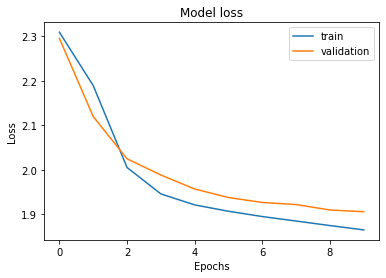

In [11]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('Model loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend(['train', 'validation'], loc='upper right')

plt.show()


In [ ]:
model.evaluate(x_val_features, y_val)